In [8]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

loop7_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/7loopfeats.csv"))
loop8_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/8loopfeats.csv"))
loop9_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/9loopfeats.csv"))
loop10_data = pd.read_csv(Path("/Users/rezadoobary/Documents/ML-correlator/Tree classifier for graphs/mixed_loops/features_tabular/10loopfeats.csv"))

#pairwise stratifications

loop7_data['loops'] = 7
loop8_data['loops'] = 8
loop9_data['loops'] = 9
loop10_data['loops'] = 10

all_loops = pd.concat([loop7_data, loop8_data, loop9_data,loop10_data], axis = 0)

Fold 1 AUC (train folds on loops [7, 8, 9]): 0.898
Fold 1 AUC (loop 10): 0.806
Fold 2 AUC (train folds on loops [7, 8, 9]): 0.892
Fold 2 AUC (loop 10): 0.809
Fold 3 AUC (train folds on loops [7, 8, 9]): 0.902
Fold 3 AUC (loop 10): 0.816
Fold 4 AUC (train folds on loops [7, 8, 9]): 0.899
Fold 4 AUC (loop 10): 0.820
Fold 5 AUC (train folds on loops [7, 8, 9]): 0.900
Fold 5 AUC (loop 10): 0.818

Average ROC AUC on training fold (loops [7, 8, 9]): 0.898 ± 0.003
Average ROC AUC on loop 10: 0.814 ± 0.005


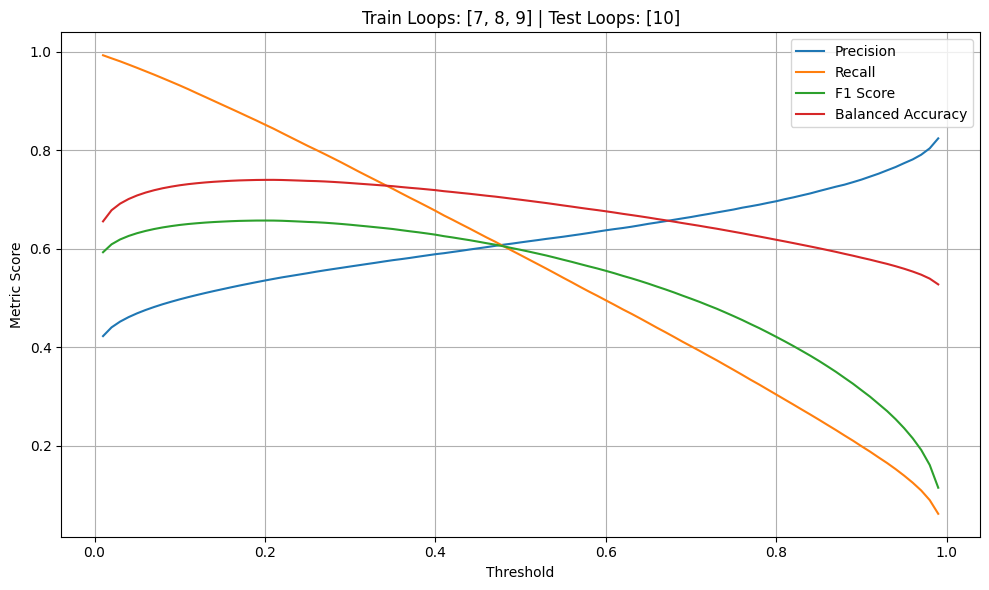

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Define loops to use ---
train_loops = [7,8, 9]
test_loops = [10]

# --- Split data ---
train_data = all_loops[all_loops['loops'].isin(train_loops)]
test_data = all_loops[all_loops['loops'].isin(test_loops)]

# --- Columns ---
data_cols = [col for col in all_loops.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'

# --- Train data ---
X_train_full = train_data[data_cols].values
y_train_full = train_data[target_col].values.ravel()

# --- Test data ---
X_test = test_data[data_cols].values
y_test = test_data[target_col].values.ravel()
loop_test = test_data['loops'].values

# --- Thresholds for metric curves ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- AUC trackers ---
train_val_aucs = []  # loop(s) used for training cross-val
test_loop_aucs = {loop: [] for loop in test_loops}  # aucs for each test loop

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    # --- AUC on validation set (from train loop group) ---
    val_scores = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_scores)
    train_val_aucs.append(val_auc)
    print(f"Fold {fold+1} AUC (train folds on loops {train_loops}): {val_auc:.3f}")

    # --- AUC on each test loop
    test_scores = model.predict_proba(X_test)[:, 1]
    for loop_id in test_loops:
        mask = loop_test == loop_id
        if mask.sum() > 0:
            auc = roc_auc_score(y_test[mask], test_scores[mask])
            test_loop_aucs[loop_id].append(auc)
            print(f"Fold {fold+1} AUC (loop {loop_id}): {auc:.3f}")
        else:
            print(f"Fold {fold+1} has no samples for loop {loop_id}")

    # --- Threshold metrics (on all test loops combined) ---
    for i, t in enumerate(thresholds):
        y_pred = (test_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Print AUC summaries ---
print(f"\nAverage ROC AUC on training fold (loops {train_loops}): {np.mean(train_val_aucs):.3f} ± {np.std(train_val_aucs):.3f}")
for loop_id in test_loops:
    aucs = test_loop_aucs[loop_id]
    print(f"Average ROC AUC on loop {loop_id}: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# --- Plot metrics vs threshold ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Train Loops: {train_loops} | Test Loops: {test_loops}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# --------------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------------
alpha = 0.1                 # target mis-coverage (90 % coverage)
train_loops = [7, 8, 9]     # loops used for CV-training
test_loops  = [10]          # loops held out for final test
n_splits    = 5             # CV folds

# --------------------------------------------------------------------------
# DATA (assumes `all_loops` DataFrame already in memory)
# --------------------------------------------------------------------------
# Example loading stub; replace with your real CSV/parquet loader if needed
# all_loops = pd.read_csv("features.csv")

train_data = all_loops[all_loops["loops"].isin(train_loops)]
test_data  = all_loops[all_loops["loops"].isin(test_loops)]

data_cols   = [c for c in all_loops.columns if "COEFFICIENTS" not in c]
target_col  = "COEFFICIENTS"

X_train_full = train_data[data_cols].values
y_train_full = train_data[target_col].values.ravel()

X_test  = test_data[data_cols].values
y_test  = test_data[target_col].values.ravel()
loop_id_test = test_data["loops"].values        # to keep loop id per row

# --------------------------------------------------------------------------
# STORAGE FOR SUMMARY
# --------------------------------------------------------------------------
plain_aucs          = []
coverages           = []
singleton_aucs      = []

# per-loop plain AUC and singleton AUC trackers
plain_aucs_loop     = {L: [] for L in test_loops}
singleton_aucs_loop = {L: [] for L in test_loops}
coverages_loop      = {L: [] for L in test_loops}

# --------------------------------------------------------------------------
# CROSS-VALIDATION
# --------------------------------------------------------------------------
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (tr_idx, calib_idx) in enumerate(kf.split(X_train_full, y_train_full), 1):
    X_tr,    y_tr    = X_train_full[tr_idx],    y_train_full[tr_idx]
    X_calib, y_calib = X_train_full[calib_idx], y_train_full[calib_idx]

    # ---- train model ------------------------------------------------------
    model = XGBClassifier(eval_metric="logloss")
    model.fit(X_tr, y_tr)

    # ---- split-conformal calibration -------------------------------------
    p_calib = model.predict_proba(X_calib)            # (n_calib, 2)
    calib_scores = 1.0 - p_calib[np.arange(len(y_calib)), y_calib]   # non-conformity
    q = np.quantile(calib_scores, 1 - alpha, method="higher")

    # ---- predictions on test set -----------------------------------------
    p_test   = model.predict_proba(X_test)[:, 1]      # score = P(class 1)
    sets     = []

    # build conformal prediction sets
    for p0 in p_test:
        pred_set = set()
        if 1 - (1 - p0) <= q: pred_set.add(0)   # score for class 0 is 1-p1
        if 1 - p0       <= q: pred_set.add(1)
        sets.append(pred_set)

    # ---- metrics ----------------------------------------------------------
    # overall plain ROC AUC
    plain_auc = roc_auc_score(y_test, p_test)
    plain_aucs.append(plain_auc)

    # coverage
    cov = np.mean([y_test[i] in sets[i] for i in range(len(y_test))])
    coverages.append(cov)

    # singleton AUC (if any)
    mask_single = np.array([len(s) == 1 for s in sets])
    if mask_single.any() and len(np.unique(y_test[mask_single])) > 1:
        singleton_auc = roc_auc_score(y_test[mask_single], p_test[mask_single])
    else:
        singleton_auc = np.nan
    singleton_aucs.append(singleton_auc)

    # ---- per-loop log -----------------------------------------------------
    for L in test_loops:
        m = loop_id_test == L
        if m.sum():
            plain_auc_loop = roc_auc_score(y_test[m], p_test[m])
            plain_aucs_loop[L].append(plain_auc_loop)

            cov_loop = np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if m[i]])
            coverages_loop[L].append(cov_loop)

            mask_single_loop = mask_single & m
            if mask_single_loop.any() and len(np.unique(y_test[mask_single_loop])) > 1:
                s_auc = roc_auc_score(y_test[mask_single_loop], p_test[mask_single_loop])
            else:
                s_auc = np.nan
            singleton_aucs_loop[L].append(s_auc)

    # ---- fold report ------------------------------------------------------
    print(f"[Fold {fold}]  plain AUC={plain_auc:.3f} | "
          f"coverage={cov:.3f} | singleton AUC={singleton_auc:.3f}")

# --------------------------------------------------------------------------
# SUMMARY
# --------------------------------------------------------------------------
def mean_std(arr):
    arr = np.asarray(arr, dtype=float)
    return np.nanmean(arr), np.nanstd(arr)

print("\n=== Overall test metrics across CV folds ===")
m, s = mean_std(plain_aucs)
print(f"Plain ROC AUC        : {m:.3f} ± {s:.3f}")
m, s = mean_std(coverages)
print(f"Conformal coverage   : {m:.3f} ± {s:.3f}")
m, s = mean_std(singleton_aucs)
print(f"Singleton ROC AUC    : {m:.3f} ± {s:.3f}")

for L in test_loops:
    pa, sa = mean_std(plain_aucs_loop[L]), mean_std(singleton_aucs_loop[L])
    cv = mean_std(coverages_loop[L])
    print(f"\nLoop {L}:")
    print(f"  Plain AUC      : {pa[0]:.3f} ± {pa[1]:.3f}")
    print(f"  Coverage       : {cv[0]:.3f} ± {cv[1]:.3f}")
    print(f"  Singleton AUC  : {sa[0]:.3f} ± {sa[1]:.3f}")


[Fold 1]  plain AUC=0.806 | coverage=0.845 | singleton AUC=0.856
[Fold 2]  plain AUC=0.809 | coverage=0.848 | singleton AUC=0.856
[Fold 3]  plain AUC=0.816 | coverage=0.838 | singleton AUC=0.852
[Fold 4]  plain AUC=0.820 | coverage=0.850 | singleton AUC=0.857
[Fold 5]  plain AUC=0.818 | coverage=0.845 | singleton AUC=0.862

=== Overall test metrics across CV folds ===
Plain ROC AUC        : 0.814 ± 0.005
Conformal coverage   : 0.845 ± 0.004
Singleton ROC AUC    : 0.857 ± 0.003

Loop 10:
  Plain AUC      : 0.814 ± 0.005
  Coverage       : 0.845 ± 0.004
  Singleton AUC  : 0.857 ± 0.003


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# --------------------------------------------------------------------------
# CONFIGURATION -------------------------------------------------------------
alpha        = 0.01                 # target mis-coverage  (90 % coverage)
train_loops  = [7, 8, 9]            # loops used for CV-training
test_loops   = [10]                 # loops held out for final test
n_splits     = 5                    # CV folds

# --------------------------------------------------------------------------
# DATA ----------------------------------------------------------------------
# all_loops must be a DataFrame already in memory:
#  • features  … any columns except "COEFFICIENTS"
#  • target    … column "COEFFICIENTS"  (binary 0/1)
#  • helper    … column "loops"         (the loop number)
#
# Example stub (uncomment if you need to load):
#   all_loops = pd.read_csv("features.csv")
# --------------------------------------------------------------------------
train_data = all_loops[all_loops["loops"].isin(train_loops)]
test_data  = all_loops[all_loops["loops"].isin(test_loops)]

feature_cols = [c for c in all_loops.columns if c not in {"COEFFICIENTS", "loops"}]
target_col   = "COEFFICIENTS"

X_train_full = train_data[feature_cols].values
y_train_full = train_data[target_col].values.ravel()

X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_ids = test_data["loops"].values

# --------------------------------------------------------------------------
# STORAGE FOR FOLD-LEVEL METRICS -------------------------------------------
plain_aucs, coverages, singleton_aucs, singleton_counts = [], [], [], []

plain_aucs_loop      = {L: [] for L in test_loops}
coverages_loop       = {L: [] for L in test_loops}
singleton_aucs_loop  = {L: [] for L in test_loops}
singleton_counts_loop= {L: [] for L in test_loops}

# --------------------------------------------------------------------------
# STRATIFIED 5-FOLD CV ------------------------------------------------------
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (tr_idx, calib_idx) in enumerate(kf.split(X_train_full, y_train_full), 1):
    # --- split -------------------------------------------------------------
    X_tr,    y_tr    = X_train_full[tr_idx],    y_train_full[tr_idx]
    X_calib, y_calib = X_train_full[calib_idx], y_train_full[calib_idx]

    # --- train XGBoost -----------------------------------------------------
    model = XGBClassifier(eval_metric="logloss")
    model.fit(X_tr, y_tr)

    # --- split-conformal threshold ----------------------------------------
    p_calib   = model.predict_proba(X_calib)
    conf_score= 1.0 - p_calib[np.arange(len(y_calib)), y_calib]
    q         = np.quantile(conf_score, 1 - alpha, method="higher")

    # --- test predictions --------------------------------------------------
    p_test  = model.predict_proba(X_test)[:, 1]   # P(class 1)
    sets    = []
    for p1 in p_test:                             # p0 = 1-p1
        s = set()
        if (1 - (1 - p1)) <= q: s.add(0)
        if (1 - p1)       <= q: s.add(1)
        sets.append(s)

    # --- fold-level metrics -----------------------------------------------
    plain_auc    = roc_auc_score(y_test, p_test)
    coverage     = np.mean([y_test[i] in sets[i] for i in range(len(y_test))])
    mask_single  = np.array([len(s) == 1 for s in sets])
    n_singletons = mask_single.sum()
    if n_singletons and len(np.unique(y_test[mask_single])) > 1:
        singleton_auc = roc_auc_score(y_test[mask_single], p_test[mask_single])
    else:
        singleton_auc = np.nan

    plain_aucs.append(plain_auc)
    coverages.append(coverage)
    singleton_aucs.append(singleton_auc)
    singleton_counts.append(n_singletons/len(X_test))

    # --- per-loop bookkeeping ---------------------------------------------
    for L in test_loops:
        m = loop_ids == L
        if not m.any(): continue
        plain_aucs_loop[L].append(roc_auc_score(y_test[m], p_test[m]))
        coverages_loop[L].append(
            np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if m[i]])
        )
        mask_single_L = mask_single & m
        if mask_single_L.any() and len(np.unique(y_test[mask_single_L])) > 1:
            s_auc = roc_auc_score(y_test[mask_single_L], p_test[mask_single_L])
        else:
            s_auc = np.nan
        singleton_aucs_loop[L].append(s_auc)
        singleton_counts_loop[L].append(mask_single_L.sum()/len(X_test))

    # --- fold report -------------------------------------------------------
    print(f"[Fold {fold}]  "
          f"plain AUC={plain_auc:.3f} | "
          f"coverage={coverage:.3f} | "
          f"singleton AUC={singleton_auc:.3f} | "
          f"# singletons={n_singletons/len(X_test)}")

# --------------------------------------------------------------------------
# SUMMARY HELPERS -----------------------------------------------------------
def mean_std(a):
    a = np.asarray(a, dtype=float)
    return np.nanmean(a), np.nanstd(a)

# --------------------------------------------------------------------------
# GLOBAL SUMMARY ------------------------------------------------------------
print("\n=== Overall test metrics across CV folds ===")
print("Plain ROC AUC        : %.3f ± %.3f" % mean_std(plain_aucs))
print("Conformal coverage   : %.3f ± %.3f" % mean_std(coverages))
print("Singleton ROC AUC    : %.3f ± %.3f" % mean_std(singleton_aucs))
print("Avg # singleton sets : %.1f ± %.1f"
      % mean_std(singleton_counts))

# --------------------------------------------------------------------------
# PER-LOOP SUMMARY ----------------------------------------------------------
for L in test_loops:
    print(f"\nLoop {L}:")
    print("  Plain ROC AUC        : %.3f ± %.3f" % mean_std(plain_aucs_loop[L]))
    print("  Coverage             : %.3f ± %.3f" % mean_std(coverages_loop[L]))
    print("  Singleton ROC AUC    : %.3f ± %.3f" % mean_std(singleton_aucs_loop[L]))
    print("  Avg # singleton sets : %.1f ± %.1f"
          % mean_std(singleton_counts_loop[L]))


[Fold 1]  plain AUC=0.806 | coverage=0.971 | singleton AUC=0.944 | # singletons=0.36754495863022996
[Fold 2]  plain AUC=0.809 | coverage=0.966 | singleton AUC=0.930 | # singletons=0.417332237099679
[Fold 3]  plain AUC=0.816 | coverage=0.970 | singleton AUC=0.929 | # singletons=0.3998120742306789
[Fold 4]  plain AUC=0.820 | coverage=0.977 | singleton AUC=0.940 | # singletons=0.371551431628951
[Fold 5]  plain AUC=0.818 | coverage=0.978 | singleton AUC=0.953 | # singletons=0.36677498499203925

=== Overall test metrics across CV folds ===
Plain ROC AUC        : 0.814 ± 0.005
Conformal coverage   : 0.972 ± 0.005
Singleton ROC AUC    : 0.939 ± 0.009
Avg # singleton sets : 0.4 ± 0.0

Loop 10:
  Plain ROC AUC        : 0.814 ± 0.005
  Coverage             : 0.972 ± 0.005
  Singleton ROC AUC    : 0.939 ± 0.009
  Avg # singleton sets : 0.4 ± 0.0


In [12]:
# uq_split_conformal_singleton_cov.py
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

"""
Split-conformal uncertainty quantification for binary classification with:
- Plain ROC AUC on the held-out test loops
- Conformal coverage on the test loops
- Singleton ROC AUC (AUC restricted to examples whose conformal set has size 1)
- Single-prediction coverage (coverage restricted to singleton sets only)
- Per-loop summaries

Assumes a DataFrame `all_loops` is already in memory with:
  * features  : any columns except "COEFFICIENTS" and "loops"
  * target    : column "COEFFICIENTS" (binary 0/1)
  * helper    : column "loops" (loop number)
"""

# --------------------------------------------------------------------------
# CONFIGURATION -------------------------------------------------------------
alpha        = 0.01                 # target miscoverage (target coverage ≈ 1 - alpha = 0.99)
train_loops  = [7, 8, 9]            # loops used for CV-training
test_loops   = [10]                 # loops held out for final test
n_splits     = 5                    # CV folds
rng_seed     = 42

# --------------------------------------------------------------------------
# DATA ----------------------------------------------------------------------
# If you prefer to load from disk, uncomment and point to your CSV:
# all_loops = pd.read_csv("features.csv")

# Expect `all_loops` to exist at this point:
try:
    all_loops
except NameError as e:
    raise RuntimeError(
        "This script expects a DataFrame named `all_loops` in memory. "
        "Either create it before running or uncomment the CSV-loading stub."
    ) from e

train_data = all_loops[all_loops["loops"].isin(train_loops)]
test_data  = all_loops[all_loops["loops"].isin(test_loops)]

feature_cols = [c for c in all_loops.columns if c not in {"COEFFICIENTS", "loops"}]
target_col   = "COEFFICIENTS"

X_train_full = train_data[feature_cols].values
y_train_full = train_data[target_col].values.ravel()

X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_ids = test_data["loops"].values

# --------------------------------------------------------------------------
# STORAGE FOR FOLD-LEVEL METRICS -------------------------------------------
plain_aucs, coverages = [], []
singleton_aucs, singleton_counts = [], []
single_coverages = []  # NEW: coverage only among singleton prediction sets

plain_aucs_loop       = {L: [] for L in test_loops}
coverages_loop        = {L: [] for L in test_loops}
singleton_aucs_loop   = {L: [] for L in test_loops}
singleton_counts_loop = {L: [] for L in test_loops}
single_coverages_loop = {L: [] for L in test_loops}  # NEW

# --------------------------------------------------------------------------
# STRATIFIED K-FOLD ON TRAIN LOOPS (train/calib) ----------------------------
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng_seed)

for fold, (tr_idx, calib_idx) in enumerate(kf.split(X_train_full, y_train_full), 1):
    # --- split -------------------------------------------------------------
    X_tr,    y_tr    = X_train_full[tr_idx],    y_train_full[tr_idx]
    X_calib, y_calib = X_train_full[calib_idx], y_train_full[calib_idx]

    # --- train XGBoost -----------------------------------------------------
    model = XGBClassifier(eval_metric="logloss", random_state=rng_seed, n_jobs=-1)
    model.fit(X_tr, y_tr)

    # --- split-conformal threshold ----------------------------------------
    p_calib    = model.predict_proba(X_calib)
    conf_score = 1.0 - p_calib[np.arange(len(y_calib)), y_calib]  # 1 - P(true class)
    q = np.quantile(conf_score, 1 - alpha, method="higher")

    # --- test predictions --------------------------------------------------
    p_test = model.predict_proba(X_test)[:, 1]  # P(class 1)
    sets   = []
    for p1 in p_test:
        s = set()
        # Include label 0 if score(0) = 1 - p0 = p1 <= q
        if p1 <= q:
            s.add(0)
        # Include label 1 if score(1) = 1 - p1 <= q
        if (1 - p1) <= q:
            s.add(1)
        sets.append(s)

    # --- fold-level metrics -----------------------------------------------
    plain_auc   = roc_auc_score(y_test, p_test)
    coverage    = np.mean([y_test[i] in sets[i] for i in range(len(y_test))])

    mask_single  = np.array([len(s) == 1 for s in sets])
    n_singletons = mask_single.sum()

    # NEW: coverage conditional on singleton sets only
    if n_singletons:
        single_coverage = np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if mask_single[i]])
    else:
        single_coverage = np.nan

    # AUC among singletons (only if both classes present)
    if n_singletons and len(np.unique(y_test[mask_single])) > 1:
        singleton_auc = roc_auc_score(y_test[mask_single], p_test[mask_single])
    else:
        singleton_auc = np.nan

    plain_aucs.append(plain_auc)
    coverages.append(coverage)
    singleton_aucs.append(singleton_auc)
    singleton_counts.append(n_singletons / len(X_test))
    single_coverages.append(single_coverage)  # NEW

    # --- per-loop bookkeeping ---------------------------------------------
    for L in test_loops:
        m = (loop_ids == L)
        if not m.any():
            continue

        # Plain AUC for this loop (may error if only one class present; guard if needed)
        try:
            plain_aucs_loop[L].append(roc_auc_score(y_test[m], p_test[m]))
        except ValueError:
            plain_aucs_loop[L].append(np.nan)

        # Coverage on this loop
        cov_L = np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if m[i]])
        coverages_loop[L].append(cov_L)

        # Singletons on this loop
        mask_single_L = mask_single & m

        # NEW: single-prediction coverage per loop
        if mask_single_L.any():
            scov_L = np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if mask_single_L[i]])
        else:
            scov_L = np.nan
        single_coverages_loop[L].append(scov_L)

        # Singleton AUC per loop (guard for class diversity)
        if mask_single_L.any() and len(np.unique(y_test[mask_single_L])) > 1:
            s_auc = roc_auc_score(y_test[mask_single_L], p_test[mask_single_L])
        else:
            s_auc = np.nan
        singleton_aucs_loop[L].append(s_auc)

        # Fraction of test examples that are singletons contributed by this loop
        singleton_counts_loop[L].append(mask_single_L.sum() / len(X_test))

    # --- fold report -------------------------------------------------------
    print(
        f"[Fold {fold}] plain AUC={plain_auc:.3f} | "
        f"coverage={coverage:.3f} | "
        f"single-pred coverage={single_coverage:.3f} | "
        f"singleton AUC={singleton_auc:.3f} | "
        f"# singletons={n_singletons/len(X_test):.3f}"
    )

# --------------------------------------------------------------------------
# SUMMARY HELPERS -----------------------------------------------------------
def mean_std(a):
    a = np.asarray(a, dtype=float)
    return np.nanmean(a), np.nanstd(a)

# --------------------------------------------------------------------------
# GLOBAL SUMMARY ------------------------------------------------------------
print("\n=== Overall test metrics across CV folds ===")
print("Plain ROC AUC              : %.3f ± %.3f" % mean_std(plain_aucs))
print("Conformal coverage         : %.3f ± %.3f" % mean_std(coverages))
print("Single-prediction coverage : %.3f ± %.3f" % mean_std(single_coverages))  # NEW
print("Singleton ROC AUC          : %.3f ± %.3f" % mean_std(singleton_aucs))
print("Avg # singleton sets       : %.1f ± %.1f" % mean_std(singleton_counts))

# --------------------------------------------------------------------------
# PER-LOOP SUMMARY ----------------------------------------------------------
for L in test_loops:
    print(f"\nLoop {L}:")
    print("  Plain ROC AUC              : %.3f ± %.3f" % mean_std(plain_aucs_loop[L]))
    print("  Coverage                   : %.3f ± %.3f" % mean_std(coverages_loop[L]))
    print("  Single-prediction coverage : %.3f ± %.3f" % mean_std(single_coverages_loop[L]))  # NEW
    print("  Singleton ROC AUC          : %.3f ± %.3f" % mean_std(singleton_aucs_loop[L]))
    print("  Avg # singleton sets       : %.1f ± %.1f" % mean_std(singleton_counts_loop[L]))


[Fold 1] plain AUC=0.806 | coverage=0.971 | single-pred coverage=0.921 | singleton AUC=0.944 | # singletons=0.368
[Fold 2] plain AUC=0.809 | coverage=0.966 | single-pred coverage=0.919 | singleton AUC=0.930 | # singletons=0.417
[Fold 3] plain AUC=0.816 | coverage=0.970 | single-pred coverage=0.925 | singleton AUC=0.929 | # singletons=0.400
[Fold 4] plain AUC=0.820 | coverage=0.977 | single-pred coverage=0.937 | singleton AUC=0.940 | # singletons=0.372
[Fold 5] plain AUC=0.818 | coverage=0.978 | single-pred coverage=0.941 | singleton AUC=0.953 | # singletons=0.367

=== Overall test metrics across CV folds ===
Plain ROC AUC              : 0.814 ± 0.005
Conformal coverage         : 0.972 ± 0.005
Single-prediction coverage : 0.928 ± 0.009
Singleton ROC AUC          : 0.939 ± 0.009
Avg # singleton sets       : 0.4 ± 0.0

Loop 10:
  Plain ROC AUC              : 0.814 ± 0.005
  Coverage                   : 0.972 ± 0.005
  Single-prediction coverage : 0.928 ± 0.009
  Singleton ROC AUC         

In [13]:
singleton_counts_loop

{10: [np.float64(0.36754495863022996),
  np.float64(0.417332237099679),
  np.float64(0.3998120742306789),
  np.float64(0.371551431628951),
  np.float64(0.36677498499203925)]}

[Fold 1] plain AUC=0.847 | coverage=0.162 | confident AUC=0.977 | hard-acc=0.394 | #conf=0.16230130765014486
[Fold 2] plain AUC=0.850 | coverage=0.175 | confident AUC=0.974 | hard-acc=0.401 | #conf=0.17471876386605067
[Fold 3] plain AUC=0.845 | coverage=0.173 | confident AUC=0.985 | hard-acc=0.404 | #conf=0.17296348497898886
[Fold 4] plain AUC=0.844 | coverage=0.162 | confident AUC=0.971 | hard-acc=0.395 | #conf=0.16163573721713256
[Fold 5] plain AUC=0.845 | coverage=0.163 | confident AUC=0.979 | hard-acc=0.395 | #conf=0.1626079920653564

=== Bootstrapped metrics across CV folds ===
Plain ROC AUC        : 0.846 ± 0.002
Coverage (σ≤0.010)    : 0.167 ± 0.006
Confident ROC AUC    : 0.977 ± 0.005
Hard accuracy        : 0.398 ± 0.004
Avg # confident sets : 0.2 ± 0.0

Loop 10:
  Plain ROC AUC     : 0.846 ± 0.002
  Coverage          : 0.167 ± 0.006
  Confident ROC AUC : 0.977 ± 0.005
  Hard accuracy     : 0.000 ± 0.000
  Avg # confident   : 0.2 ± 0.0


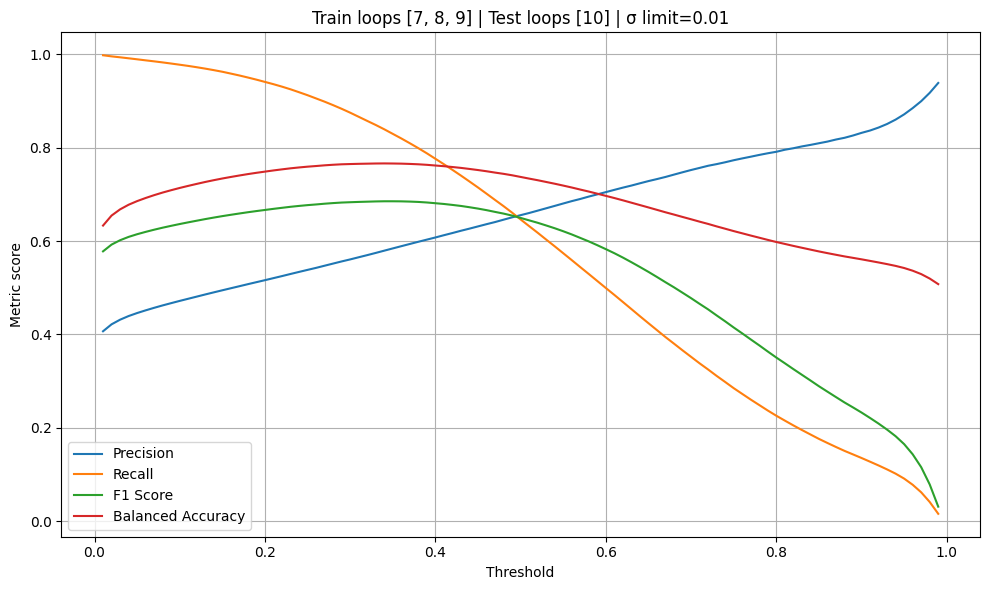

In [ ]:
# ---------------------------------------------------------------------------
#  Bootstrapped-XGBoost with confidence filtering
# ---------------------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (roc_auc_score, accuracy_score,
                             precision_score, recall_score,
                             f1_score, balanced_accuracy_score)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ---------- USER PARAMETERS -------------------------------------------------
N_BOOT     = 30      # bootstrap resamples per CV fold
STD_LIMIT  = 0.01    # max allowed σ(p̂) to call a prediction “confident”
alpha      = 0.10    # kept for later if you align with CP alpha

train_loops = [7, 8, 9]
test_loops  = [10]
N_SPLITS    = 5
# ---------------------------------------------------------------------------

# ---------- DATA ------------------------------------------------------------
# all_loops must already exist as a DataFrame
#  • 'loops' column with loop id
#  • 'COEFFICIENTS' binary target
#  • feature columns = everything else

feature_cols = [c for c in all_loops.columns
                if c not in {"COEFFICIENTS", "loops"}]
target_col   = "COEFFICIENTS"

train_df = all_loops[all_loops["loops"].isin(train_loops)]
test_df  = all_loops[all_loops["loops"].isin(test_loops)]

X_train_full = train_df[feature_cols].values
y_train_full = train_df[target_col].values.ravel()

X_test   = test_df[feature_cols].values
y_test   = test_df[target_col].values.ravel()
loop_ids = test_df["loops"].values

# ---------- THRESHOLD CURVE STORAGE ----------------------------------------
thresholds          = np.linspace(0.01, 0.99, 99)
precisions          = np.zeros_like(thresholds)
recalls             = np.zeros_like(thresholds)
f1s                 = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# ---------- FOLD-LEVEL TRACKERS --------------------------------------------
plain_aucs, coverages, conf_aucs = [], [], []
conf_hard_accs, n_conf_all = [], []

plain_aucs_loop     = {L: [] for L in test_loops}
coverages_loop      = {L: [] for L in test_loops}
conf_aucs_loop      = {L: [] for L in test_loops}
conf_hard_accs_loop = {L: [] for L in test_loops}
n_conf_loop         = {L: [] for L in test_loops}

# ---------- STRATIFIED K-FOLD ----------------------------------------------
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (tr_idx, calib_idx) in enumerate(kf.split(X_train_full, y_train_full), 1):
    X_tr, y_tr = X_train_full[tr_idx], y_train_full[tr_idx]

    # ---- BOOTSTRAP ENSEMBLE ----------------------------------------------
    boot_preds_test = np.zeros((N_BOOT, len(X_test)))

    for b in range(N_BOOT):
        bs_idx = np.random.choice(len(X_tr), len(X_tr), replace=True)
        X_bs, y_bs = X_tr[bs_idx], y_tr[bs_idx]

        model = XGBClassifier(eval_metric="logloss")
        model.fit(X_bs, y_bs)

        boot_preds_test[b] = model.predict_proba(X_test)[:, 1]

    # ---- MEAN & STD across bootstraps ------------------------------------
    mean_prob = boot_preds_test.mean(axis=0)
    std_prob  = boot_preds_test.std(axis=0)

    # ---- FOLD-LEVEL METRICS ----------------------------------------------
    plain_auc = roc_auc_score(y_test, mean_prob)
    plain_aucs.append(plain_auc)

    confident = std_prob <= STD_LIMIT
    coverage  = confident.mean()
    coverages.append(coverage)
    n_conf_all.append(confident.sum()/len(X_test))

    # confident ROC AUC
    if confident.any() and len(np.unique(y_test[confident])) > 1:
        conf_auc = roc_auc_score(y_test[confident], mean_prob[confident])
    else:
        conf_auc = np.nan
    conf_aucs.append(conf_auc)

    # HARD ACCURACY metrics
    y_pred_class = (mean_prob >= 0.5).astype(int)
    cp_hard_acc = accuracy_score(
        y_test,
        np.where(confident, y_pred_class, 1 - y_pred_class)  # wrong if not confident
    )
    conf_hard_accs.append(cp_hard_acc)

    # ---- per-loop bookkeeping -------------------------------------------
    for L in test_loops:
        m = loop_ids == L
        if not m.any(): continue
        plain_aucs_loop[L].append(roc_auc_score(y_test[m], mean_prob[m]))
        coverages_loop[L].append(confident[m].mean())
        n_conf_loop[L].append(confident[m].sum()/len(X_test))

        conf_mask_loop = confident & m
        if conf_mask_loop.any() and len(np.unique(y_test[conf_mask_loop])) > 1:
            conf_auc_loop = roc_auc_score(
                y_test[conf_mask_loop], mean_prob[conf_mask_loop])
        else:
            conf_auc_loop = np.nan
        conf_aucs_loop[L].append(conf_auc_loop)

        cp_hard_loop = accuracy_score(
            y_test[m],
            np.where(confident[m], y_pred_class[m], 1 - y_pred_class[m]))
        conf_hard_accs_loop[L].append(cp_hard_loop/len(X_test))

    # ---- THRESHOLD CURVES (all test points) ------------------------------
    for i, t in enumerate(thresholds):
        y_bin = (mean_prob >= t).astype(int)
        precisions[i]          += precision_score(y_test, y_bin, zero_division=0)
        recalls[i]             += recall_score(y_test, y_bin)
        f1s[i]                 += f1_score(y_test, y_bin)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_bin)

    # ---- fold log --------------------------------------------------------
    print(f"[Fold {fold}] plain AUC={plain_auc:.3f} | "
          f"coverage={coverage:.3f} | confident AUC={conf_auc:.3f} | "
          f"hard-acc={cp_hard_acc:.3f} | #conf={confident.sum()/len(X_test)}")

# ---------- AVERAGE THRESHOLD CURVES ---------------------------------------
precisions          /= N_SPLITS
recalls             /= N_SPLITS
f1s                 /= N_SPLITS
balanced_accuracies /= N_SPLITS

# ---------- SUMMARY HELPERS ------------------------------------------------
def mean_std(arr):
    arr = np.asarray(arr, dtype=float)
    return np.nanmean(arr), np.nanstd(arr)

# ---------- GLOBAL SUMMARY -------------------------------------------------
print("\n=== Bootstrapped metrics across CV folds ===")
print("Plain ROC AUC        : %.3f ± %.3f" % mean_std(plain_aucs))
print("Coverage (σ≤%.3f)    : %.3f ± %.3f" % (STD_LIMIT, *mean_std(coverages)))
print("Confident ROC AUC    : %.3f ± %.3f" % mean_std(conf_aucs))
print("Hard accuracy        : %.3f ± %.3f" % mean_std(conf_hard_accs))
print("Avg # confident sets : %.1f ± %.1f" % mean_std(n_conf_all))

for L in test_loops:
    print(f"\nLoop {L}:")
    print("  Plain ROC AUC     : %.3f ± %.3f" % mean_std(plain_aucs_loop[L]))
    print("  Coverage          : %.3f ± %.3f" % mean_std(coverages_loop[L]))
    print("  Confident ROC AUC : %.3f ± %.3f" % mean_std(conf_aucs_loop[L]))
    print("  Hard accuracy     : %.3f ± %.3f" % mean_std(conf_hard_accs_loop[L]))
    print("  Avg # confident   : %.3f ± %.3f" % mean_std(n_conf_loop[L]))

# ---------- PLOT METRIC CURVES ---------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric score")
plt.title(f"Train loops {train_loops} | Test loops {test_loops} "
          f"| σ limit={STD_LIMIT}")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [18]:
# uq_split_conformal_no_cv.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

"""
Split-conformal UQ (no CV):
- Train on loops 7,8,9 (with a stratified calibration split from these loops)
- Test on loop 10
- Metrics: Plain AUC, Conformal coverage, Single-prediction coverage,
           Singleton ROC AUC, and per-loop singleton fraction/count (Loop 10)

Input expectation:
  DataFrame `all_loops` is already in memory with:
    * features  : any columns except "COEFFICIENTS" and "loops"
    * target    : column "COEFFICIENTS" (binary 0/1)
    * helper    : column "loops" (loop number)
"""

# --------------------------------------------------------------------------
# CONFIGURATION -------------------------------------------------------------
alpha         = 0.01        # target miscoverage (target coverage ≈ 1 - alpha)
train_loops   = [7, 8, 9]   # loops used for model fit + calibration split
test_loops    = [10]        # loop(s) held out for final test
calib_size    = 0.2         # fraction of (7,8,9) reserved for calibration
rng_seed      = 42

# --------------------------------------------------------------------------
# DATA ----------------------------------------------------------------------
# Expect `all_loops` to exist at this point:
try:
    all_loops
except NameError as e:
    raise RuntimeError(
        "This script expects a DataFrame named `all_loops` in memory. "
        "Create it beforehand (or load from CSV) with required columns."
    ) from e

train_data = all_loops[all_loops["loops"].isin(train_loops)].copy()
test_data  = all_loops[all_loops["loops"].isin(test_loops)].copy()

feature_cols = [c for c in all_loops.columns if c not in {"COEFFICIENTS", "loops"}]
target_col   = "COEFFICIENTS"

X_train_all = train_data[feature_cols].values
y_train_all = train_data[target_col].values.ravel()

X_test   = test_data[feature_cols].values
y_test   = test_data[target_col].values.ravel()
loop_ids = test_data["loops"].values

# --------------------------------------------------------------------------
# HELPERS -------------------------------------------------------------------
def safe_auc(y_true, scores):
    """ROC AUC or NaN if only one class present."""
    y_true = np.asarray(y_true)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, scores)

# --------------------------------------------------------------------------
# TRAIN/CALIB SPLIT (from loops 7,8,9) -------------------------------------
X_tr, X_calib, y_tr, y_calib = train_test_split(
    X_train_all, y_train_all,
    test_size=calib_size, random_state=rng_seed, stratify=y_train_all
)

# --------------------------------------------------------------------------
# TRAIN MODEL ---------------------------------------------------------------
model = XGBClassifier(eval_metric="logloss", random_state=rng_seed, n_jobs=-1)
model.fit(X_tr, y_tr)

# --------------------------------------------------------------------------
# CALIBRATE CONFORMAL THRESHOLD --------------------------------------------
# Nonconformity score: 1 - P(true_label)
p_calib    = model.predict_proba(X_calib)
conf_score = 1.0 - p_calib[np.arange(len(y_calib)), y_calib]
# Use "higher" for split-conformal validity
q = np.quantile(conf_score, 1 - alpha, method="higher")

# --------------------------------------------------------------------------
# TEST EVALUATION (Loop 10) -------------------------------------------------
p_test = model.predict_proba(X_test)[:, 1]  # P(class 1)

# Build prediction sets
sets = []
for p1 in p_test:
    s = set()
    # Include label 0 if score(0) = 1 - P(0) = p1 <= q
    if p1 <= q:
        s.add(0)
    # Include label 1 if score(1) = 1 - p1 <= q
    if (1 - p1) <= q:
        s.add(1)
    sets.append(s)

# Metrics on full test
plain_auc = safe_auc(y_test, p_test)
coverage  = np.mean([y_test[i] in sets[i] for i in range(len(y_test))])

mask_single  = np.array([len(s) == 1 for s in sets])
n_singletons = int(mask_single.sum())

single_coverage = (
    np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if mask_single[i]])
    if n_singletons else np.nan
)

singleton_auc = safe_auc(y_test[mask_single], p_test[mask_single]) if n_singletons else np.nan

# --------------------------------------------------------------------------
# PER-LOOP SUMMARY (Loop 10) -----------------------------------------------
for L in test_loops:
    m = (loop_ids == L)
    if not m.any():
        continue

    plain_auc_L = safe_auc(y_test[m], p_test[m])

    cov_L = np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if m[i]])

    mask_single_L  = mask_single & m
    n_in_loop      = int(m.sum())
    n_singletons_L = int(mask_single_L.sum())

    single_cov_L = (
        np.mean([y_test[i] in sets[i] for i in range(len(y_test)) if mask_single_L[i]])
        if n_singletons_L else np.nan
    )

    singleton_auc_L = (
        safe_auc(y_test[mask_single_L], p_test[mask_single_L]) if n_singletons_L else np.nan
    )

    singleton_frac_L = (n_singletons_L / n_in_loop) if n_in_loop else np.nan

    # ------------------- PRINT RESULTS ------------------------------------
    print("\n=== Test results (train on loops 7,8,9; test on loop %d) ===" % L)
    print("Plain ROC AUC             : %.3f" % plain_auc)
    print("Conformal coverage        : %.3f" % coverage)
    print("Single-prediction coverage: %.3f" % single_coverage)
    print("Singleton ROC AUC         : %.3f" % singleton_auc)

    #print("Plain ROC AUC                 : %.3f" % plain_auc_L)
    ##print("\n--- Per-loop summary (Loop %d) ---" % L)
    #print("Coverage                      : %.3f" % cov_L)
    #print("Single-prediction coverage    : %.3f" % single_cov_L)
    #print("Singleton ROC AUC             : %.3f" % singleton_auc_L)
    #print("Singleton fraction (per loop) : %.3f" % singleton_frac_L)
    #print("# singleton sets (count)      : %d" % n_singletons_L)



=== Test results (train on loops 7,8,9; test on loop 10) ===
Plain ROC AUC             : 0.832
Conformal coverage        : 0.977
Single-prediction coverage: 0.940
Singleton ROC AUC         : 0.949


In [19]:
p_calib    = model.predict_proba(X_calib)
conf_score = 1.0 - p_calib[np.arange(len(y_calib)), y_calib]
# Use "higher" for split-conformal validity
q = np.quantile(conf_score, 1 - alpha, method="higher")

In [22]:
p_calib[np.arange(len(y_calib)), y_calib]

array([0.98585796, 0.8106995 , 0.62379706, ..., 0.9448312 , 0.9722748 ,
       0.7650514 ], shape=(3114,), dtype=float32)

In [25]:
q

np.float32(0.94462407)

In [30]:
p_test[3]

np.float32(0.9273525)

In [32]:
np.mean([len(s) == 1 for s in sets])

np.float64(0.39025265575653173)

In [34]:
df = pd.read_csv('/Users/rezadoobary/Documents/ML-correlator/Graph_Edge_Data/den_graph_data_11.csv')

In [35]:
len(df)

1697302

In [36]:
df = pd.read_csv('/Users/rezadoobary/Documents/ML-correlator/Graph_Edge_Data/den_graph_data_10.csv')
len(df)

153252